In [1]:
#Import necessary libraries
import pandas as pd  
import numpy as np
import math
import os
import glob
import zipfile
import concurrent.futures
from datetime import timedelta, datetime
import warnings
warnings.filterwarnings('ignore')

#--------------------------------------------------------------------------------------------
#Set the path to the Excel file containing survey results
path = r'D:\Data Science\SurveyResults.xlsx'

#Creating date time based on individual columns of time, date, start time, end time etc.
excel = pd.read_excel(path, usecols=['ID', 'Start time', 'End time', 'date', 'Stress level'], dtype={'ID': str})
excel['Stress level'].replace('na', np.nan, inplace=True)
excel.dropna(inplace=True)

excel['Start datetime'] =  pd.to_datetime(excel['date'].map(str) + ' ' + excel['Start time'].map(str))
excel['End datetime'] =  pd.to_datetime(excel['date'].map(str) + ' ' + excel['End time'].map(str))
excel.drop(['Start time', 'End time', 'date'], axis=1, inplace=True)

# Convert SurveyResults.xlsx to GMT-00:00
daylight = pd.to_datetime(datetime(2020, 11, 1, 0, 0))

excel1 = excel[excel['End datetime'] <= daylight].copy()
excel1['Start datetime'] = excel1['Start datetime'].apply(lambda x: x + timedelta(hours=5))
excel1['End datetime'] = excel1['End datetime'].apply(lambda x: x + timedelta(hours=5))

excel2 = excel.loc[excel['End datetime'] > daylight].copy()
excel2['Start datetime'] = excel2['Start datetime'].apply(lambda x: x + timedelta(hours=6))
excel2['End datetime'] = excel2['End datetime'].apply(lambda x: x + timedelta(hours=6))

excel = pd.concat([excel1, excel2], ignore_index=True)
excel['datetime'] = excel['End datetime'] - excel['Start datetime']

#Creating minutes columns for labeling 
def minutes(x):
    return x.seconds/60

excel['time'] = excel['datetime'].apply(minutes)

excel.reset_index(drop=True, inplace=True)

#--------------------------------------------------------------------------------------------
#To tell the time of execution
#%%time
#glob package is used to get all the folders inside the path specified
folders = glob.glob(os.path.join(r"D:\Data Science\Data\*"))
#--------------------------------------------------------------------------------------------

a = 0
#creating new dataframe to hold all the data
final = pd.DataFrame()

#looping through all the folders to extract the files
#for j in range(len(folders)):
for j in range(1):
    #glob package is again used for each of the looping folders to extract .zip files
    files = glob.glob(os.path.join(folders[j]+'\*.zip'))
    
    #looping through each zip files to unzip the files
    for i in range(len(files)):
    
        zf = zipfile.ZipFile(files[i])
        def unzip(file):
            zf.extract(file)
        with concurrent.futures.ThreadPoolExecutor() as executor:
            executor.map(unzip, zf.infolist())
      
#--------------------------------------------------------------------------------------------
        #unzipping and reaching the files
        ACC = pd.read_csv('ACC.csv')
        BVP = pd.read_csv('BVP.csv')
        EDA = pd.read_csv('EDA.csv')
        HR = pd.read_csv('HR.csv')
        file_stat = os.stat('IBI.csv')
        #if file_stat.st_size > 0:
        #    IBI = pd.read_csv('IBI.csv')
        TEMP = pd.read_csv('TEMP.csv')

#--------------------------------------------------------------------------------------------
        #Creating Date Time for each dataset based on timestamp
    
        ACC['id'] = folders[j][-2:]
        def process_df(df):
            start_timestamp = df.iloc[0,0]
            sample_rate = df.iloc[1,0]
            new_df = pd.DataFrame(df.iloc[2:].values, columns=df.columns)
            new_df['datetime'] = [(start_timestamp + i/sample_rate) for i in range(len(new_df))]
            return new_df
        
        ACC = process_df(ACC)
        BVP = process_df(BVP)
        EDA = process_df(EDA)
        HR = process_df(HR)
        TEMP = process_df(TEMP)
#-------------------------------------------------------------------------------------------- 
        #renaming the columns to our needs
        ACC.rename({ACC.columns[0]:'accelerometer_X',ACC.columns[1]:'accelerometer_Y',ACC.columns[2]:'accelerometer_Z'},axis = 1,inplace = True)
        BVP.rename({BVP.columns[0]:'BVP'},axis = 1,inplace = True)
        EDA.rename({EDA.columns[0]:'EDA'},axis = 1,inplace = True)
        HR.rename({HR.columns[0]:'heart_rate'},axis = 1,inplace=True)
        #IBI.rename({IBI.columns[0]:'IBI_0',IBI.columns[1]:'IBI_1'},axis = 1,inplace = True)
        TEMP.rename({TEMP.columns[0]:'temp'},axis = 1,inplace = True)
        
#--------------------------------------------------------------------------------------------
        #Merging the Data
        new = ACC.merge(EDA, on='datetime', how='outer')
        new = new.merge(TEMP, on='datetime', how='outer')
        new = new.merge(HR, on='datetime', how='outer')
        
        #Fill null value by forward and backward fill
        
        new.fillna(method='ffill', inplace=True)
        new.fillna(method='bfill', inplace=True)
        new.reset_index(inplace = True,drop = True)
        
#--------------------------------------------------------------------------------------------
        #Appending and concating the final merged files
        if j == 0:
            final = new.append(final)
        else:
            final = pd.concat([final,new],ignore_index = True)
        a += 1
        print('The file number:- ',a,' of folder:- ',j,' is done')
    
    a = 0
    print('The folder number:-', j,' is done')

The file number:-  1  of folder:-  0  is done
The file number:-  2  of folder:-  0  is done
The file number:-  3  of folder:-  0  is done
The file number:-  4  of folder:-  0  is done
The file number:-  5  of folder:-  0  is done
The file number:-  6  of folder:-  0  is done
The file number:-  7  of folder:-  0  is done
The file number:-  8  of folder:-  0  is done
The file number:-  9  of folder:-  0  is done
The file number:-  10  of folder:-  0  is done
The file number:-  11  of folder:-  0  is done
The file number:-  12  of folder:-  0  is done
The file number:-  13  of folder:-  0  is done
The file number:-  14  of folder:-  0  is done
The file number:-  15  of folder:-  0  is done
The file number:-  16  of folder:-  0  is done
The file number:-  17  of folder:-  0  is done
The file number:-  18  of folder:-  0  is done
The file number:-  19  of folder:-  0  is done
The file number:-  20  of folder:-  0  is done
The file number:-  21  of folder:-  0  is done
The file number:-  22 

In [2]:
#Labelling based on datetime
#Convert the 'id' column in 'final' and 'ID' column in 'excel' to string data type
final['id'] = final['id'].astype('str')
excel['ID'] = excel['ID'].astype('str')
#Define a function to label rows in 'final' as 1 or 0 based on the 'datetime' column
def label(x):
    if x>= excel['time'].max(): # if the datetime value is greater than or equal to the maximum time in 'excel'
        return 1  # assign the label 1
    else:
        return 0  # otherwise, assign the label 0
#Apply the 'label' function to the 'datetime' column in 'final' and assign the result to a new 'Label' column
final['Label'] = final['datetime'].apply(label)

 Data preprocessing and saving of merged file is done

# Data Cleaning/ Model Building life cycle begins

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
data = pd.read_csv('Preprocessed.csv')

#drop unecessary columns
data.drop({'Unnamed: 0','datetime','id'},axis = 1,inplace = True)

In [5]:
data.head()

,accelerometer_X,accelerometer_Y,accelerometer_Z,EDA,temp,heart_rate,Label
0,-27.0,4.0,56.0,0.185782,31.11,95.98,0
1,-26.0,4.0,57.0,0.185782,31.11,95.98,0
2,-32.0,1.0,59.0,0.185782,31.11,95.98,0
3,-37.0,0.0,57.0,0.185782,31.11,95.98,0
4,-37.0,-1.0,54.0,0.185782,31.11,95.98,0


In [6]:
data.isnull().sum()

accelerometer_X    0
accelerometer_Y    0
accelerometer_Z    0
EDA                0
temp               0
heart_rate         0
Label              0
dtype: int64

In [7]:
#check duplicates
data.duplicated().sum()

6316177

In [8]:
#drop duplicates
data.drop_duplicates(inplace = True)

In [9]:
data.dtypes

accelerometer_X    float64
accelerometer_Y    float64
accelerometer_Z    float64
EDA                float64
temp               float64
heart_rate         float64
Label                int64
dtype: object

In [10]:
data.describe()

,accelerometer_X,accelerometer_Y,accelerometer_Z,EDA,temp,heart_rate,Label
count,4.444196e+06,4.444196e+06,4.444196e+06,4.444196e+06,4.444196e+06,4.444196e+06,4.444196e+06
mean,-3.938895e+01,-3.906693e+00,8.456852e+00,6.077870e-01,3.163512e+01,6.935415e+01,6.590618e-02
std,2.613035e+01,3.611379e+01,3.303936e+01,1.746508e+00,1.672380e+00,1.371243e+01,2.481181e-01
min,-1.280000e+02,-1.280000e+02,-1.280000e+02,0.000000e+00,2.403000e+01,5.050000e+01,0.000000e+00
25%,-5.800000e+01,-3.000000e+01,-1.600000e+01,1.921900e-02,3.029000e+01,5.850000e+01,0.000000e+00
50%,-4.400000e+01,0.000000e+00,9.000000e+00,2.204020e-01,3.139000e+01,6.600000e+01,0.000000e+00
75%,-2.500000e+01,2.200000e+01,3.400000e+01,8.124620e-01,3.309000e+01,7.900000e+01,0.000000e+00
max,1.270000e+02,1.270000e+02,1.270000e+02,4.357153e+01,3.637000e+01,1.586500e+02,1.000000e+00


In [11]:
data.shape

(4444196, 7)

In [12]:
#imbalanced which can be balanced by upsampling using SMOTE or downsampling (not preferred method)
data['Label'].value_counts()

0    4151296
1     292900
Name: Label, dtype: int64

<AxesSubplot:xlabel='Label', ylabel='count'>

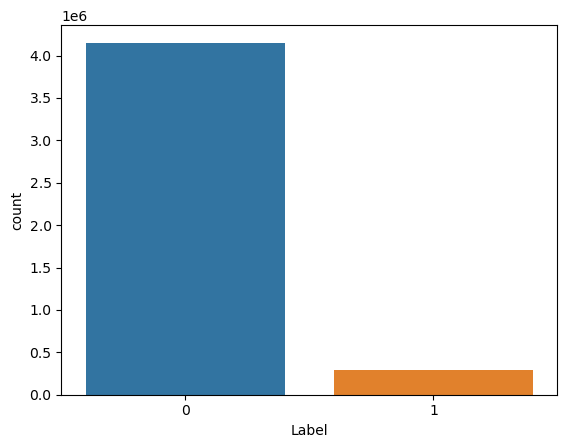

In [13]:
sns.countplot(data['Label'])

# Resampling the Data Label 

In [57]:
#As the above value counts and the visulization representing the total rows in the dataset which contains 0's and the total 
# rows in the dataset which contains 1's the ratio between them is 10:1 which suggests the data is imbalanced and we should
#either downsample or upsample to balance out the dependent varaible beforte fitting into the model

In [14]:
from sklearn.utils import resample

In [15]:
#seperating zeros and ones because we have to downsample zero and keep the ones same
downsize_0 = data[data['Label'] == 0]
keep_ones = data[data['Label'] == 1]

In [16]:
zeros = resample(downsize_0, n_samples=len(keep_ones), replace=True)

#Finally merging ones and resampled zeros
new_data = pd.concat([keep_ones,zeros]).reset_index(drop = True)

In [17]:
new_data.head()

,accelerometer_X,accelerometer_Y,accelerometer_Z,EDA,temp,heart_rate,Label
0,-52.0,8.0,-39.0,0.230626,31.11,73.0,1
1,-52.0,8.0,-39.0,0.258813,31.11,73.0,1
2,-52.0,8.0,-39.0,0.271626,31.11,73.0,1
3,-52.0,8.0,-39.0,0.274188,31.11,73.0,1
4,-52.0,8.0,-39.0,0.275470,31.11,73.0,1


In [18]:
new_data['Label'].value_counts()

1    292900
0    292900
Name: Label, dtype: int64

<AxesSubplot:xlabel='Label', ylabel='count'>

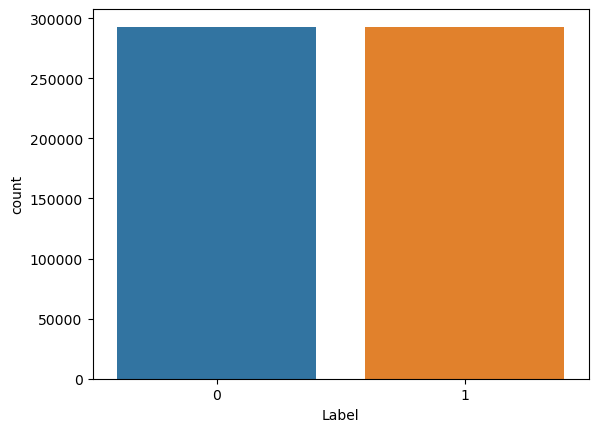

In [19]:
sns.countplot(new_data['Label'])

In [20]:
#Correlation tab shows us which features are highly positivey correlated and highly negatively correlated
new_data.corr()

,accelerometer_X,accelerometer_Y,accelerometer_Z,EDA,temp,heart_rate,Label
accelerometer_X,1.000000,-0.005114,0.270804,-0.075723,-0.016019,0.032043,0.043247
accelerometer_Y,-0.005114,1.000000,0.081079,-0.172629,0.034522,-0.165832,-0.243826
accelerometer_Z,0.270804,0.081079,1.000000,-0.056785,-0.034688,0.005089,-0.082050
EDA,-0.075723,-0.172629,-0.056785,1.000000,0.236486,-0.000182,0.459628
temp,-0.016019,0.034522,-0.034688,0.236486,1.000000,-0.114751,0.045282
heart_rate,0.032043,-0.165832,0.005089,-0.000182,-0.114751,1.000000,0.088910
Label,0.043247,-0.243826,-0.082050,0.459628,0.045282,0.088910,1.000000


<AxesSubplot:>

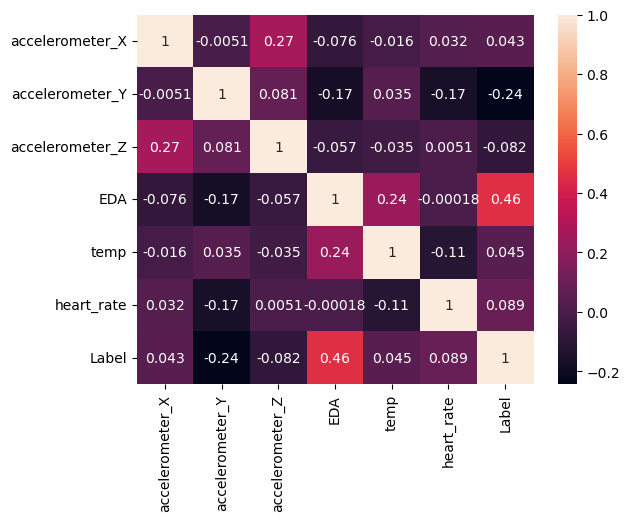

In [21]:
sns.heatmap(new_data.corr(),annot = True)

array([[<AxesSubplot:title={'center':'accelerometer_X'}>,
        <AxesSubplot:title={'center':'accelerometer_Y'}>,
        <AxesSubplot:title={'center':'accelerometer_Z'}>],
       [<AxesSubplot:title={'center':'EDA'}>,
        <AxesSubplot:title={'center':'temp'}>,
        <AxesSubplot:title={'center':'heart_rate'}>],
       [<AxesSubplot:title={'center':'Label'}>, <AxesSubplot:>,
        <AxesSubplot:>]], dtype=object)

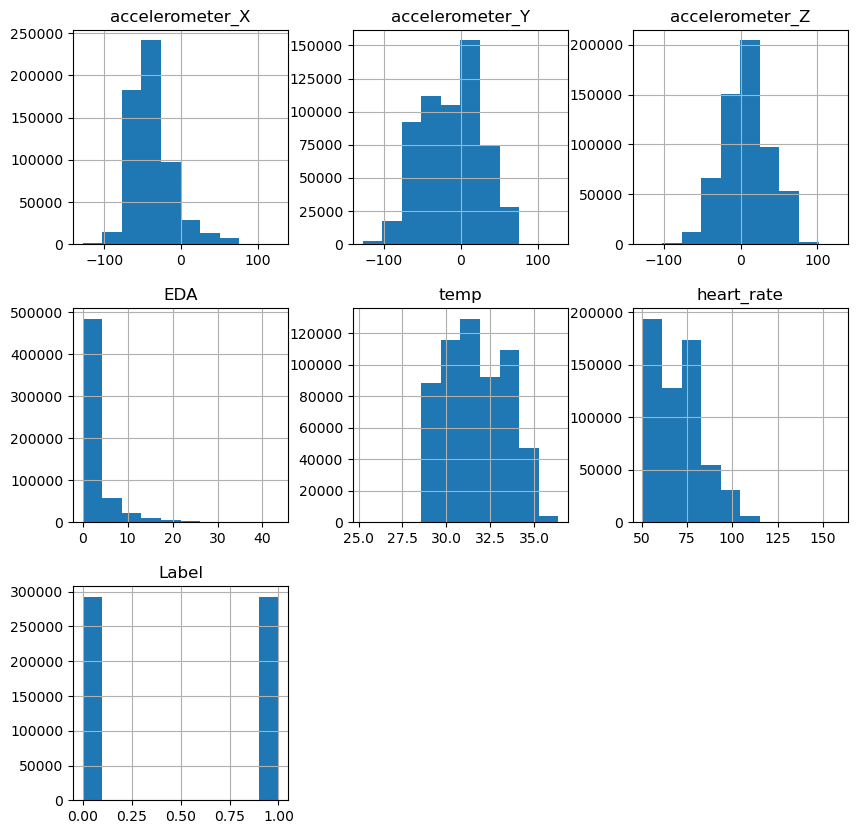

In [22]:
#Histogram suggests which feature is normally distributed
new_data.hist(figsize = (10,10))

# Splitting the data into Training set and Testing Set

In [23]:
from sklearn.model_selection import train_test_split

In [24]:
X = new_data.drop({'Label'},axis = 1)
y = new_data['Label']

#Splitting the data into training and testing using sklearn package
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.35, random_state=100)

In [25]:
X_train.shape,y_train.shape,X_test.shape,y_test.shape

((380770, 6), (380770,), (205030, 6), (205030,))

# Feature Engineering

In [26]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import mutual_info_classif

In [27]:
#Feature selection using sklearn by select the best number of k features and mutual information of feature selection
feature = SelectKBest(score_func=mutual_info_classif, k='all')

feature.fit(X_train, y_train)

feature_value = []
for i in range(len(feature.scores_)):
 print('Feature importance of %d: %f' % (i, feature.scores_[i]))
 feature_value.append(feature.scores_[i])

Feature importance of 0: 0.171351
Feature importance of 1: 0.242644
Feature importance of 2: 0.217013
Feature importance of 3: 0.671730
Feature importance of 4: 0.115659
Feature importance of 5: 0.109837


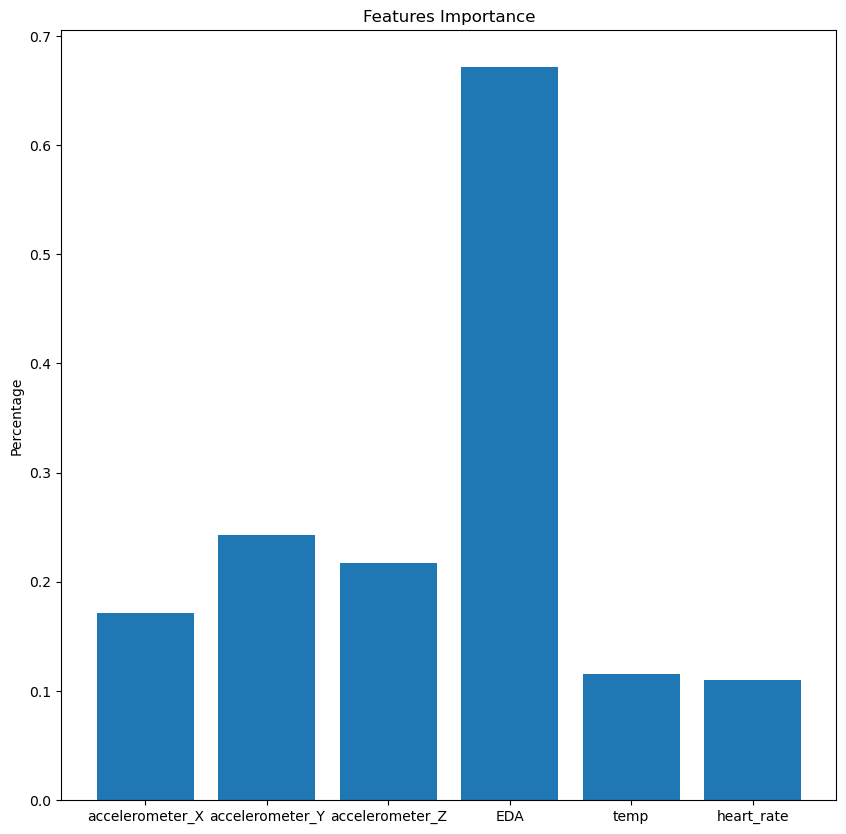

In [28]:
# Set the x-axis labels
labels = list(new_data.columns)[0:6]

# Create a bar plot
fig, ax = plt.subplots(figsize = (10,10))
ax.bar(np.arange(len(feature_value)), feature_value)
ax.set_xticks(np.arange(len(feature_value)))
ax.set_xticklabels(labels)
ax.set_ylabel('Percentage')
ax.set_title('Features Importance')

plt.show()

# Fitting the preprocessed data to algorithm to build Models

# Logistic Regression Algorithm

In [29]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

In [30]:
Logistic_regression = LogisticRegression(random_state=0).fit(X_train, y_train)

y_pred_1 = Logistic_regression.predict(X_test)

In [31]:
print(classification_report(y_test, y_pred_1))

              precision    recall  f1-score   support

           0       0.75      0.92      0.82    102581
           1       0.90      0.69      0.78    102449

    accuracy                           0.80    205030
   macro avg       0.82      0.80      0.80    205030
weighted avg       0.82      0.80      0.80    205030



<AxesSubplot:>

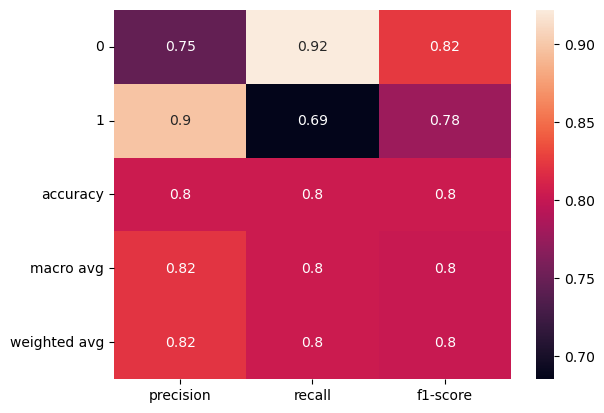

In [32]:
report_1 = classification_report(y_test, y_pred_1,output_dict=True)

sns.heatmap(pd.DataFrame(report_1).iloc[:-1, :].T, annot=True)

# K-Nearest-Neighbour Algorithm

In [33]:
from sklearn.neighbors import KNeighborsClassifier

In [34]:
neigh = KNeighborsClassifier(n_neighbors=5)
neigh.fit(X_train, y_train)

#Predicting 
y_pred_2 = neigh.predict(X_test)

In [35]:
print(classification_report(y_test, y_pred_2))

              precision    recall  f1-score   support

           0       0.98      0.96      0.97    102581
           1       0.96      0.98      0.97    102449

    accuracy                           0.97    205030
   macro avg       0.97      0.97      0.97    205030
weighted avg       0.97      0.97      0.97    205030



<AxesSubplot:>

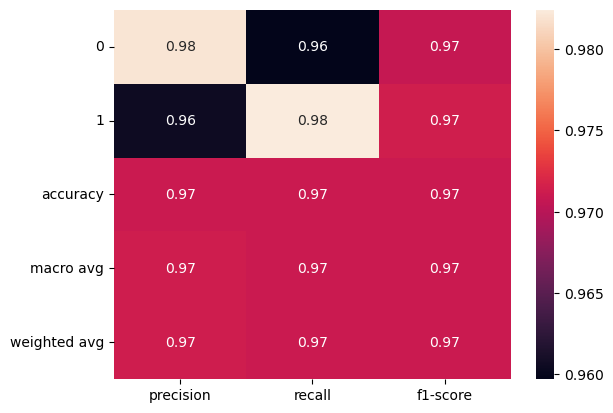

In [36]:
report_2 = classification_report(y_test, y_pred_2,output_dict=True)

sns.heatmap(pd.DataFrame(report_2).iloc[:-1, :].T, annot=True)

# Naive Bayes Algorithm

In [37]:
from sklearn.naive_bayes import GaussianNB

In [38]:
Naive_bayes = GaussianNB()
Naive_bayes.fit(X_train, y_train)

y_pred_3 = Naive_bayes.predict(X_test)

In [39]:
print(classification_report(y_test, y_pred_3))

              precision    recall  f1-score   support

           0       0.71      0.99      0.83    102581
           1       0.99      0.59      0.74    102449

    accuracy                           0.79    205030
   macro avg       0.85      0.79      0.78    205030
weighted avg       0.85      0.79      0.78    205030



<AxesSubplot:>

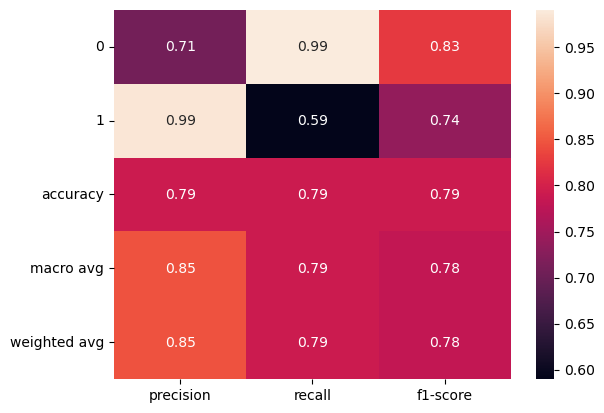

In [40]:
report_3 = classification_report(y_test, y_pred_3,output_dict=True)

sns.heatmap(pd.DataFrame(report_3).iloc[:-1, :].T, annot=True)